# Travaux pratiques 2

**Année: 2024-2025**

## Objectifs

1. **Modélisation de connaissances et interrogation de données** : Utiliser un langage logique pour structurer une base de connaissances et créer des règles permettant d’extraire des informations spécifiques à partir des données.

2. **Classification de textes et d'images** : Concevoir et entraîner des modèles de réseaux de neurones pour la classification de textes (exercice 2.2) et d'images (exercice 2.4), en maîtrisant le prétraitement des données, l'optimisation des hyperparamètres, et l'évaluation des performances des modèles.

3. **Prédiction de séquences** : Développer un modèle de prédiction pour des séquences de traductions, en appliquant des techniques de préparation de données séquentielles et en évaluant les performances du modèle sur des données de test.

- Faits
    - `eleve(Nom, Prenom, DateNaissance)`: Informations personnelles des élèves.
    - `groupe_projet(Eleve, Groupe)`: Groupes de projet auxquels les élèves appartiennent.
    - `note(Eleve, Module, Note)`: Notes des élèves dans différents modules.
    - `module(NomModule, Description)`: Liste des modules avec leur nom et description.
- Règles
    - `eleves_groupe(Groupe, Eleves)`: Trouver tous les élèves d’un groupe de projet spécifique.
    - `moyenne_notes(Eleve, Module, Moyenne)`: Calculer la moyenne des notes d’un élève dans un module.
    - `modules_suivis(Eleve, Modules)`: Lister les modules suivis par un élève.

- Exemples de requetes pour questionner la base de connaissance:
    - `?- eleves_groupe('Groupe1', Eleves).`
    - `?- moyenne_notes('Dupont', 'Math', Moyenne).`
    - `?- modules_suivis('Martin', Modules).`


# Exercice 2.2

In [7]:
%pip install tensorflow --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import seaborn as sns
import os, sys, time
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import reuters, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, GRU, Flatten, Dropout,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ===================== CONFIG =====================
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Options : '0' (tous), '1' (avertissements), '2' (informations), '3' (erreurs uniquement)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# use GPU0 for tensorflow
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Configurer les logs d'absl

tf.config.optimizer.set_jit(False)  # Désactive XLA JIT)



1. **Chargement et prétraitement des données** : 
   - Chargez le jeu de données **Reuters** à l’aide de `tf.keras.datasets.reuters`.
   - Prétraitez les données en veillant à convertir les textes en séquences de tokens numériques compatibles avec le modèle. Utilisez des techniques comme la tokenisation et le padding pour obtenir des séquences de longueur uniforme.
   - **Conseils** : Utilisez `Tokenizer` de `tf.keras.preprocessing.text` pour transformer les textes en séquences numériques et `pad_sequences` pour uniformiser la longueur des séquences.

In [9]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000)

In [10]:
(num_words, test_split) = 10000, 0.2  
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=num_words, test_split=test_split)

word_index = reuters.get_word_index()
index_to_word = {value: key for key, value in word_index.items()}
train_text = [" ".join([index_to_word.get(i - 3, "?")
                       for i in item]) for item in train_data]
test_text = [" ".join([index_to_word.get(i - 3, "?")
                      for i in item]) for item in test_data]

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  13.        ,   13.26308172,   13.52616344, ..., 2375.47383656,
        2375.73691828, 2376.        ]),
 <BarContainer object of 8982 artists>)

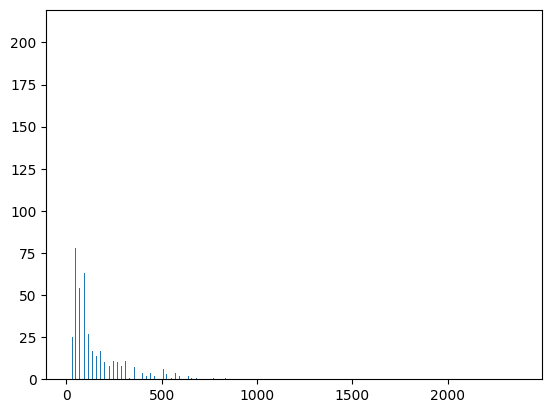

In [11]:
x_train_lenths = [len(x) for x in train_data]
plt.hist(x_train_lenths, bins=len(x_train_lenths))

In [12]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_text)

train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

sequence_lengths = [len(seq) for seq in train_sequences]
max_length = int(np.percentile(sequence_lengths, 95))  

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Vérification des nouvelles dimensions
print("Taille des séquences train :", train_padded.shape)
print("Taille des séquences test :", test_padded.shape)

Taille des séquences train : (8982, 442)
Taille des séquences test : (2246, 442)


2. **Construction d’un modèle de réseau de neurones** : 
   - Créez un modèle de réseau de neurones profond pour la classification des textes. Expérimentez avec différents types de couches pour trouver une architecture adaptée (par exemple, couches d'embedding pour les mots, couches denses, ou couches LSTM ou GRU pour capturer la structure des séquences).
   - **Conseils** : Essayez d’abord une architecture simple (comme une combinaison d’Embedding et Dense), puis explorez l’ajout de couches récurrentes pour une meilleure compréhension du contexte des mots.

In [13]:
vocab_size = 10000  
embedding_dim = 64  
num_classes = max(train_labels) + 1  

model_1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_1.build(input_shape=(None, max_length))

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model_1.summary()

/home/rodologie/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1731852339.485331   93326 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,254 (2.50 MB)

 Trainable params: 654,254 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
vocab_size = 10000  
embedding_dim = 64  
max_length = 442  
num_classes = 46  


model_2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),

    LSTM(128, return_sequences=False),  

    Dense(128, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model_2.build(input_shape=(None, max_length))

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 761,262 (2.90 MB)

 Trainable params: 761,262 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
vocab_size = 10000  
embedding_dim = 64  
max_length = 442  
num_classes = 46  


model_3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),

    Flatten(), 

    Dense(128, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model_3.build(input_shape=(None, max_length))

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,620,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,266,926 (16.28 MB)

 Trainable params: 4,266,926 (16.28 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
vocab_size = 10000  
embedding_dim = 64  
max_length = 442  
num_classes = 46  

model_4 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),

    GRU(units= 128), 

    Dense(128, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model_4.build(input_shape=(None, max_length))

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 736,942 (2.81 MB)

 Trainable params: 736,942 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_1 = model_1.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))

history_2 = model_2.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))

history_3 = model_3.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))


Epoch 1/10


I0000 00:00:1731852340.342626   96416 service.cc:148] XLA service 0x7f94c0004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731852340.342649   96416 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-11-17 15:05:40.353869: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731852340.388870   96416 cuda_dnn.cc:529] Loaded cuDNN version 90300


238/281 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.3531 - loss: 2.6363

I0000 00:00:1731852341.494094   96416 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3580 - loss: 2.5943 - val_accuracy: 0.4849 - val_loss: 2.0933
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.4883 - loss: 2.0274 - val_accuracy: 0.5637 - val_loss: 1.8376
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.5788 - loss: 1.7354 - val_accuracy: 0.6095 - val_loss: 1.6358
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6593 - loss: 1.4643 - val_accuracy: 0.6763 - val_loss: 1.4474
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.6837 - loss: 1.3270 - val_accuracy: 0.6567 - val_loss: 1.4007
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.7085 - loss: 1.2032 - val_accuracy: 0.6834 - val_loss: 1.3005
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7284 - loss: 1.1260 - val_accuracy: 0.7084 - val_loss: 1.1938
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7463 - loss: 1.0450 - val_accuracy:

In [18]:
history_4 = model_4.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))

Epoch 1/10


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3293 - loss: 2.6980 - val_accuracy: 0.3620 - val_loss: 2.4132
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3689 - loss: 2.3410 - val_accuracy: 0.5499 - val_loss: 1.7686
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5524 - loss: 1.7271 - val_accuracy: 0.5441 - val_loss: 1.7560
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5740 - loss: 1.6463 - val_accuracy: 0.5775 - val_loss: 1.6642
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5867 - loss: 1.5741 - val_accuracy: 0.5855 - val_loss: 1.6531
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6187 - loss: 1.4874 - val_accuracy: 0.6198 - val_loss: 1.6209
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6587 - loss: 1.3772 - val_accuracy: 0.6376 - val_loss: 1.5111
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6898 - loss: 1.2810 - val_accuracy: 0.633

# Cherchons maintenant les meilleurs hyper paramètres pour notre modèle

3. **Optimisation des hyperparamètres :**

Modifiez les hyperparamètres du modèle (par exemple, nombre de neurones, nombre de couches, taux d’apprentissage, nombre d’époques) et observez leur impact sur les performances du modèle.
Conseils : Commencez avec un taux d'apprentissage de base (par exemple, 0.001) et ajustez-le en fonction de la rapidité de convergence. Expérimentez également avec des tailles de batch différentes et observez leur effet.

In [19]:
history = model_4.fit(train_padded, train_labels,
                    epochs=20,       
                    batch_size=32,   
                    validation_data=(test_padded, test_labels),
                    verbose=2)      

Epoch 1/20
281/281 - 6s - 22ms/step - accuracy: 0.7377 - loss: 1.0261 - val_accuracy: 0.6474 - val_loss: 1.4189
Epoch 2/20
281/281 - 6s - 20ms/step - accuracy: 0.7572 - loss: 0.9334 - val_accuracy: 0.6612 - val_loss: 1.4214
Epoch 3/20
281/281 - 6s - 21ms/step - accuracy: 0.7743 - loss: 0.8518 - val_accuracy: 0.6496 - val_loss: 1.5600
Epoch 4/20
281/281 - 6s - 22ms/step - accuracy: 0.7983 - loss: 0.7746 - val_accuracy: 0.6857 - val_loss: 1.4513
Epoch 5/20
281/281 - 8s - 27ms/step - accuracy: 0.8182 - loss: 0.6932 - val_accuracy: 0.6928 - val_loss: 1.4492
Epoch 6/20
281/281 - 6s - 22ms/step - accuracy: 0.8352 - loss: 0.6338 - val_accuracy: 0.6843 - val_loss: 1.5238
Epoch 7/20
281/281 - 6s - 21ms/step - accuracy: 0.8434 - loss: 0.5990 - val_accuracy: 0.6906 - val_loss: 1.5142
Epoch 8/20
281/281 - 6s - 21ms/step - accuracy: 0.8576 - loss: 0.5583 - val_accuracy: 0.6888 - val_loss: 1.5991
Epoch 9/20
281/281 - 6s - 20ms/step - accuracy: 0.8644 - loss: 0.5180 - val_accuracy: 0.6830 - val_loss:

In [20]:
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.1  
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model_4.fit(train_padded, train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(test_padded, test_labels),
                    verbose=2,
                    callbacks=[lr_scheduler]) 

Epoch 1/20


141/141 - 3s - 20ms/step - accuracy: 0.9364 - loss: 0.2307 - val_accuracy: 0.7035 - val_loss: 2.1736 - learning_rate: 1.0000e-03
Epoch 2/20
141/141 - 3s - 18ms/step - accuracy: 0.9469 - loss: 0.1970 - val_accuracy: 0.7021 - val_loss: 2.2664 - learning_rate: 1.0000e-03
Epoch 3/20
141/141 - 4s - 26ms/step - accuracy: 0.9501 - loss: 0.1828 - val_accuracy: 0.6941 - val_loss: 2.3715 - learning_rate: 1.0000e-03
Epoch 4/20
141/141 - 3s - 18ms/step - accuracy: 0.9502 - loss: 0.1791 - val_accuracy: 0.6963 - val_loss: 2.3937 - learning_rate: 1.0000e-03
Epoch 5/20
141/141 - 3s - 18ms/step - accuracy: 0.9506 - loss: 0.1754 - val_accuracy: 0.7008 - val_loss: 2.4153 - learning_rate: 1.0000e-03
Epoch 6/20
141/141 - 2s - 17ms/step - accuracy: 0.9589 - loss: 0.1434 - val_accuracy: 0.6995 - val_loss: 2.4378 - learning_rate: 1.0000e-04
Epoch 7/20
141/141 - 3s - 18ms/step - accuracy: 0.9611 - loss: 0.1354 - val_accuracy: 0.7017 - val_loss: 2.4664 - learning_rate: 1.0000e-04
Epoch 8/20
141/141 - 2s - 17ms/

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)

history_4_fin = model_4.fit(train_padded, train_labels,
                        epochs=20,
                        batch_size=64,
                        validation_data=(test_padded, test_labels),
                        verbose=2,
                        callbacks=[early_stopping, lr_scheduler])  

Epoch 1/20


141/141 - 3s - 18ms/step - accuracy: 0.9618 - loss: 0.1219 - val_accuracy: 0.6986 - val_loss: 2.5481 - learning_rate: 1.0000e-06
Epoch 2/20
141/141 - 3s - 20ms/step - accuracy: 0.9618 - loss: 0.1219 - val_accuracy: 0.6986 - val_loss: 2.5486 - learning_rate: 1.0000e-06
Epoch 3/20
141/141 - 3s - 19ms/step - accuracy: 0.9620 - loss: 0.1219 - val_accuracy: 0.6986 - val_loss: 2.5490 - learning_rate: 1.0000e-06
Epoch 4/20
141/141 - 3s - 20ms/step - accuracy: 0.9621 - loss: 0.1219 - val_accuracy: 0.6981 - val_loss: 2.5494 - learning_rate: 1.0000e-06


4. **Entraînement et évaluation du modèle** :

Entraînez votre modèle en utilisant les données de Reuters et évaluez sa performance en termes de précision, rappel et score F1.
Conseils : Utilisez la fonction classification_report de sklearn.metrics pour obtenir un rapport de classification détaillé et history de Keras pour visualiser la précision et la perte au cours de l’entraînement.

Le modèle a été entrainé précédemment pendant l'ajustement des hyperparamètres

In [22]:
test_loss, test_accuracy = model_4.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7128 - loss: 2.3481
Test Accuracy: 0.6985752582550049


In [23]:
y_pred = np.argmax(model_4.predict(test_padded), axis=1)

print(classification_report(test_labels, y_pred, digits=4))


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0     0.5833    0.5833    0.5833        12
           1     0.7677    0.7238    0.7451       105
           2     0.5000    0.4000    0.4444        20
           3     0.9170    0.9237    0.9203       813
           4     0.8307    0.7869    0.8082       474
           5     0.0000    0.0000    0.0000         5
           6     0.4667    0.5000    0.4828        14
           7     0.3333    0.3333    0.3333         3
           8     0.3200    0.4211    0.3636        38
           9     0.8182    0.7200    0.7660        25
          10     0.8000    0.6667    0.7273        30
          11     0.6154    0.4819    0.5405        83
          12     0.1250    0.1538    0.1379        13
          13     0.3143    0.2973    0.3056        37
          14     0.0000    0.0000    0.0000         2
          15     0.2500    0.1111    0.1538         9
          16     0.5604    0.5152    0.536

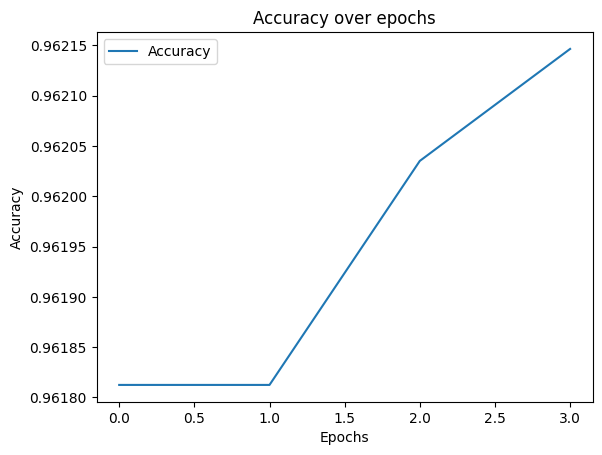

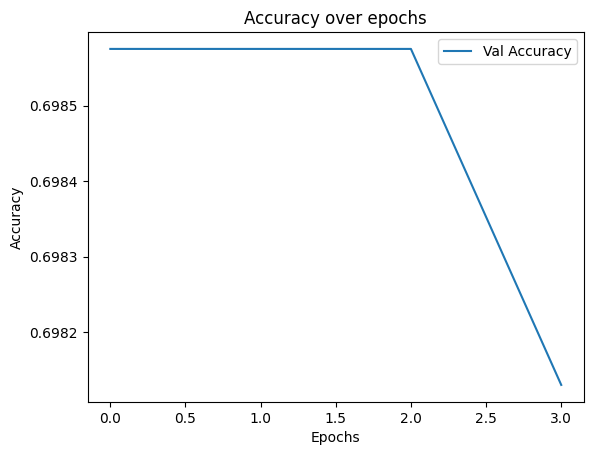

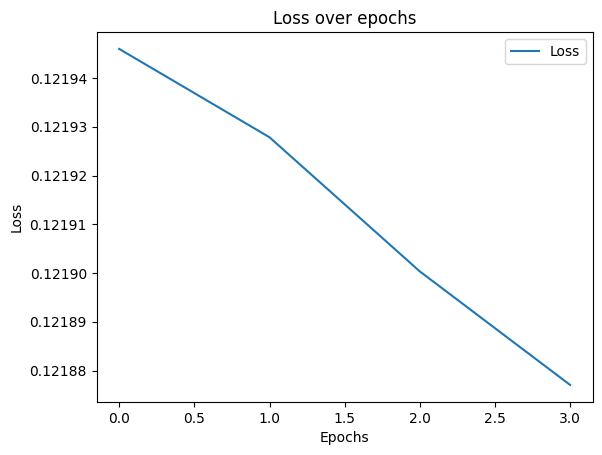

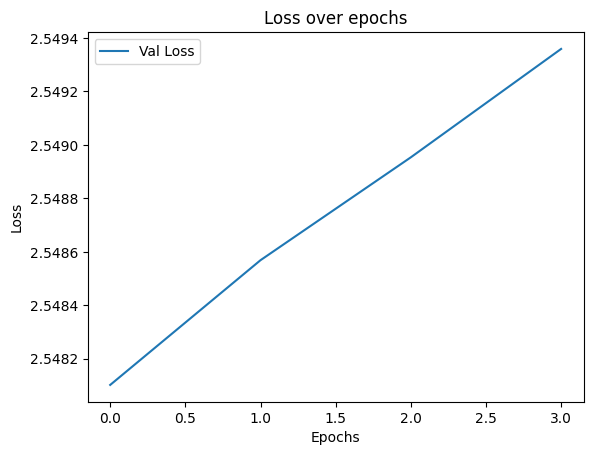

In [24]:
# Précision
plt.figure()
plt.plot(history_4_fin.history['accuracy'], label='Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_4_fin.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Perte
plt.figure()
plt.plot(history_4_fin.history['loss'], label='Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_4_fin.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Ecercice 2.3

Dans cet exercice, vous utiliserez le dataset CIFAR-10 de TensorFlow pour construire et évaluer un modèle de réseau de neurones convolutif (CNN) capable de classifier des images en 10 catégories (avions, voitures, oiseaux, chats, etc.).

1. **Chargement et Prétraitement des Données** :

- Chargez le dataset CIFAR-10 à partir de tf.keras.datasets.cifar10. Ce dataset contient 60 000 images de 32x32 pixels réparties en 10 classes, avec 50 000 images pour l'entraînement et 10 000 pour le test.
- Normalisez les valeurs des pixels des images entre 0 et 1 pour faciliter l'apprentissage.
- Appliquez des techniques d'augmentation de données (data augmentation) pour rendre le modèle plus robuste. Utilisez des transformations telles que la rotation, le zoom, et le retournement horizontal pour augmenter la diversité des images d'entraînement.

In [25]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# valeurs des pixels entre 0 et 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Shape des images d'entraînement : {x_train.shape}")
print(f"Shape des images de test : {x_test.shape}")


Shape des images d'entraînement : (50000, 32, 32, 3)
Shape des images de test : (10000, 32, 32, 3)


In [26]:
data_augmentation = ImageDataGenerator(
    rotation_range=15,          
    width_shift_range=0.1,      
    height_shift_range=0.1,    
    zoom_range=0.2,            
    horizontal_flip=True,       
    fill_mode='nearest'         
)

train_generator = data_augmentation.flow(x_train, y_train, batch_size=64)

test_generator = (x_test, y_test)

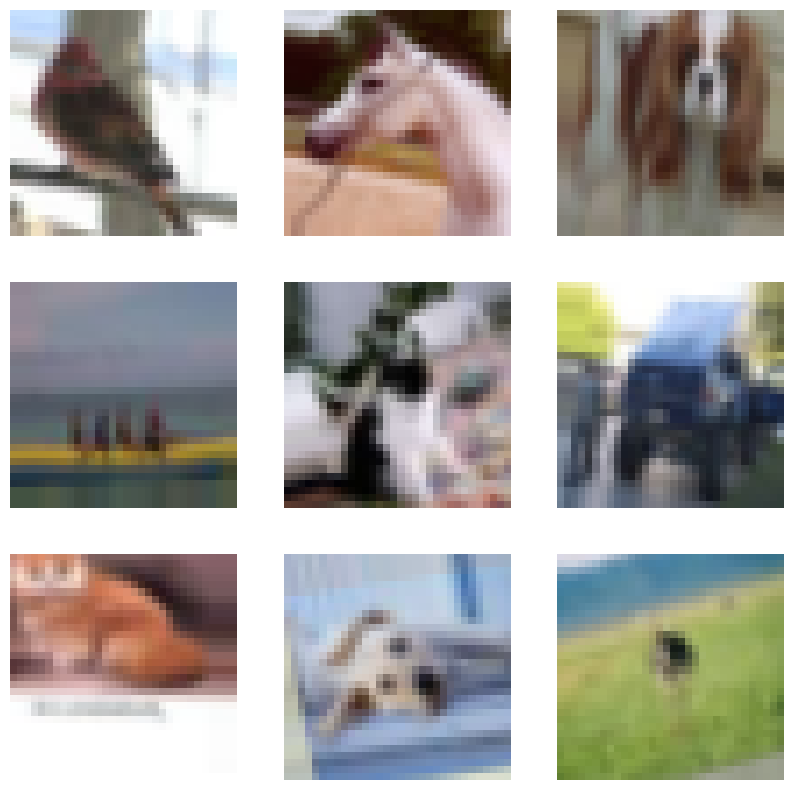

In [27]:
augmented_images, _ = next(train_generator)  
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


2. **Création d'un Modèle de Réseau de Neurones Convolutif (CNN) :**

- Concevez un modèle CNN en utilisant des couches de convolution et de pooling pour extraire les caractéristiques importantes des images.
- Structure suggérée :
   - Couche de Convolution : plusieurs filtres (par exemple, 32, 64, 128) avec une petite taille de filtre (3x3), suivis d'une activation ReLU.
   - Couche de Pooling : réduction de la taille des cartes de caractéristiques pour diminuer la complexité (par exemple, max pooling 2x2).
   - Couches Denses : après les couches convolutives, aplatissez les cartes de caractéristiques et ajoutez une ou plusieurs couches entièrement connectées pour la classification.
   - Régularisation : intégrez des techniques de régularisation comme le dropout ou la batch normalization pour éviter le surapprentissage.
- Testez différentes architectures en ajoutant ou supprimant des couches pour observer leur impact sur les performances.

In [28]:
model_cnn = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

model_cnn.summary()


/home/rodologie/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

3. **Entraînement et Optimisation du Modèle :**

- Entraînez le modèle en utilisant la fonction de perte sparse_categorical_crossentropy, car il s'agit d'un problème de classification multiclasses.
- Utilisez l’optimiseur Adam et testez différents taux d'apprentissage pour voir leur effet sur la convergence (par exemple, commencez avec 0.001).
- Ajustez d'autres hyperparamètres comme la taille de batch et le nombre d'époques, afin de trouver une configuration optimale qui équilibre précision et temps de calcul.

In [29]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']  
)

In [30]:
# Entraîner le modèle
history_cnn = model_cnn.fit(
    train_generator,           
    epochs=20,                
    validation_data=test_generator, 
    steps_per_epoch=len(x_train) // 64,  
    validation_steps=len(x_test) // 64,  
    verbose=1                 
)

Epoch 1/20


/home/rodologie/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.3144 - loss: 1.9702 - val_accuracy: 0.4296 - val_loss: 1.6953
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - accuracy: 0.4375 - loss: 1.7665 - val_accuracy: 0.4104 - val_loss: 1.7528
Epoch 3/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.3906 - loss: 1.6001

2024-11-17 15:11:16.549922: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-17 15:11:16.550035: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-17 15:11:16.559536: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-17 15:11:16.702527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous r

781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4712 - loss: 1.4688 - val_accuracy: 0.5243 - val_loss: 1.3192
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - accuracy: 0.4062 - loss: 1.4558 - val_accuracy: 0.5319 - val_loss: 1.3081
Epoch 5/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5938 - loss: 1.1072

2024-11-17 15:11:25.385054: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5281 - loss: 1.3297 - val_accuracy: 0.5799 - val_loss: 1.1641
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step - accuracy: 0.5312 - loss: 1.3815 - val_accuracy: 0.5769 - val_loss: 1.1665
Epoch 7/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6250 - loss: 1.1465

2024-11-17 15:11:34.101152: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:11:34.106524: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-17 15:11:34.106561: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701
2024-11-17 15:11:34.237123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:11:34.237160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5618 - loss: 1.2312 - val_accuracy: 0.5932 - val_loss: 1.1498
Epoch 8/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - accuracy: 0.6719 - loss: 0.9494 - val_accuracy: 0.5866 - val_loss: 1.1783
Epoch 9/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6094 - loss: 1.0960

2024-11-17 15:11:45.128396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701


781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5999 - loss: 1.1431 - val_accuracy: 0.6254 - val_loss: 1.0941
Epoch 10/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.6250 - loss: 1.2326 - val_accuracy: 0.6118 - val_loss: 1.1340
Epoch 11/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.6562 - loss: 0.9059

2024-11-17 15:11:54.251858: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:11:54.257723: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:11:54.257748: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701
2024-11-17 15:11:54.405785: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:11:54.405820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701


781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6215 - loss: 1.0864 - val_accuracy: 0.6401 - val_loss: 1.0320
Epoch 12/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step - accuracy: 0.7031 - loss: 0.8280 - val_accuracy: 0.6447 - val_loss: 1.0125
Epoch 13/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.6406 - loss: 0.9619

2024-11-17 15:12:03.459539: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-17 15:12:03.459580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:03.465469: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:03.465504: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701


781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6398 - loss: 1.0383 - val_accuracy: 0.6890 - val_loss: 0.9069
Epoch 14/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - accuracy: 0.7188 - loss: 0.9930 - val_accuracy: 0.6943 - val_loss: 0.8928
Epoch 15/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6562 - loss: 1.0338

2024-11-17 15:12:12.642325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:12.803567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729


781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6495 - loss: 1.0107 - val_accuracy: 0.6591 - val_loss: 1.0157
Epoch 16/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.6250 - loss: 1.1793 - val_accuracy: 0.6469 - val_loss: 1.0615
Epoch 17/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7031 - loss: 0.9135

2024-11-17 15:12:23.413957: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:23.419721: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:23.419751: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701


781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6679 - loss: 0.9668 - val_accuracy: 0.7049 - val_loss: 0.8393
Epoch 18/20
  1/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.0597

2024-11-17 15:12:32.616052: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:32.616093: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701
2024-11-17 15:12:32.751076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729


781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5938 - loss: 1.0597 - val_accuracy: 0.7074 - val_loss: 0.8300
Epoch 19/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6703 - loss: 0.9529 - val_accuracy: 0.6271 - val_loss: 1.1024
Epoch 20/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step - accuracy: 0.6875 - loss: 0.9600 - val_accuracy: 0.6079 - val_loss: 1.1674


2024-11-17 15:12:43.490265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:43.490303: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701
2024-11-17 15:12:43.496620: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729
2024-11-17 15:12:43.496649: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4550968158134056701
2024-11-17 15:12:43.640540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16396860153086742729


In [31]:
test_loss, test_accuracy = model_cnn.evaluate(x_test, y_test, verbose=2)

2024-11-17 15:12:43.873299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 4 bytes spill stores, 4 bytes spill loads



313/313 - 1s - 3ms/step - accuracy: 0.6079 - loss: 1.1674


4. **Évaluation et Analyse des Performances :**

- Évaluez le modèle sur l'ensemble de test et calculez la précision globale ainsi que la précision pour chaque classe.
- Générez un rapport de classification (par exemple, avec classification_report de sklearn.metrics) et une matrice de confusion pour identifier les classes où le modèle est performant et celles où des améliorations sont possibles.

In [32]:
y_pred = np.argmax(model_cnn.predict(x_test), axis=1)  # Conversion des prédictions en indices de classes
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [33]:
print("Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)], digits=4))

Rapport de classification :
              precision    recall  f1-score   support

           0     0.8183    0.5360    0.6477      1000
           1     0.6082    0.9440    0.7398      1000
           2     0.7197    0.3390    0.4609      1000
           3     0.4638    0.4420    0.4526      1000
           4     0.8090    0.3220    0.4607      1000
           5     0.7239    0.3540    0.4755      1000
           6     0.3722    0.9450    0.5340      1000
           7     0.7823    0.6790    0.7270      1000
           8     0.7930    0.7200    0.7547      1000
           9     0.6838    0.7980    0.7365      1000

    accuracy                         0.6079     10000
   macro avg     0.6774    0.6079    0.5989     10000
weighted avg     0.6774    0.6079    0.5989     10000



In [34]:
cm = confusion_matrix(y_true, y_pred)

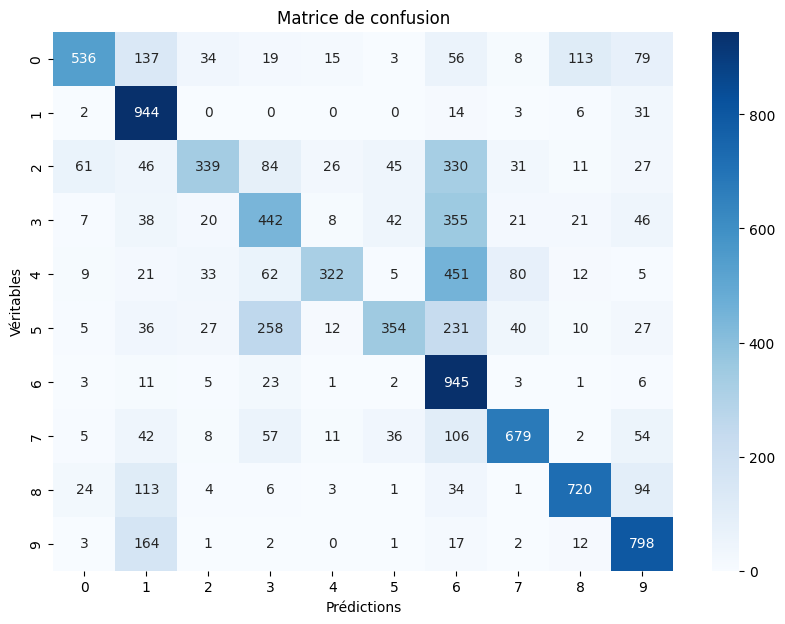

In [35]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.title('Matrice de confusion')
plt.show()

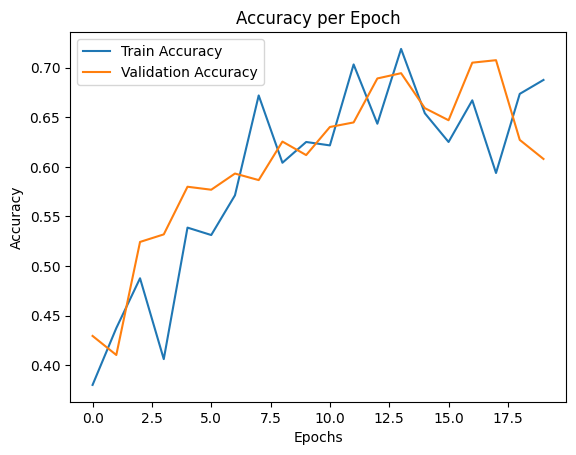

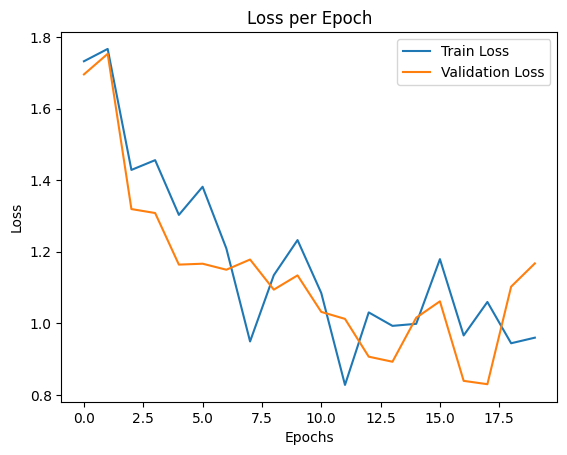

In [36]:
# Courbes de précision
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# Courbes de perte
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()
